During the work on the [last post][last_christmas] I was really surprised, that the harmonic 
oscillator Hamiltonian based on the non-local momentum operator yields good results 
even for a very coarse spatial resolution of $N=20$, whereas
a Hamiltonian based on the local second derivative matrix needs a much finer resolution,
between $N=300$ and $N=600$, for compareable eigenvalues. As the coarseness of the
discretization greatly dictates the efficiency of the numerical treatment (smaller $N$ 
mean less memory footprint and less computation time), the non-local operator
seems very promising for usage in quantum simulations.

[last_christmas]: https://znswanderer.github.io/physics/Harmonic-Oscillator-in-Discretized-Space/

But in contrast to the local operator, we could not use sparse matrices for constructing
the non-local operator. So, where 
memory usage for the local operator would scale like $\mathcal{O}(N)$, the non-local matrix is a *dense* matrix
and this means $\mathcal{O}(N^2)$ scaling.

However, we know from the [Split-step method][split], that one can circumvent this $\mathcal{O}(N^2)$ scaling
by using the [Fast Fourier Transform][fft]. In this post we will examine, how we can utilize 
this scheme.

As usual, first the necessary imports:

[split]: https://en.wikipedia.org/wiki/Split-step_method
[fft]: https://en.wikipedia.org/wiki/Fast_Fourier_transform

In [1]:
import numpy as np
from scipy import sparse
import scipy.sparse.linalg as linalg
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['figure.dpi'] = 300
plt.style.use(['science', 'notebook', 'grid', 'vibrant'])
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

We include some functionality from the last blog post:

In [3]:
class QM1DParticle:

    def __init__(self, N, L=1, hbar=1, mass=1):
        self.hbar = hbar
        self.mass = mass
        # The size of the spatioal dimension
        self.L = L
        # The resolution of the discretization of (position) space
        self.N = N
        self.x = np.linspace(0, L, N, endpoint=False)
        self.dx = np.diff(self.x)[0]
    

def psi_n(qm, n):
    """Returns the n-th momentum eigenfunction ($E_n$, $k_n$, $\psi_n$) for
    the quantum system qm
    """
    k_n = 2 * np.pi * n / qm.L
    E_n = k_n**2 * qm.hbar**2 / (2 * qm.mass)
    psi = np.exp(1j * k_n * qm.x)
    psi /= np.sqrt(psi.T.conj() @ psi * qm.dx)
    return E_n, k_n, psi

Now, let's test the FFT routines

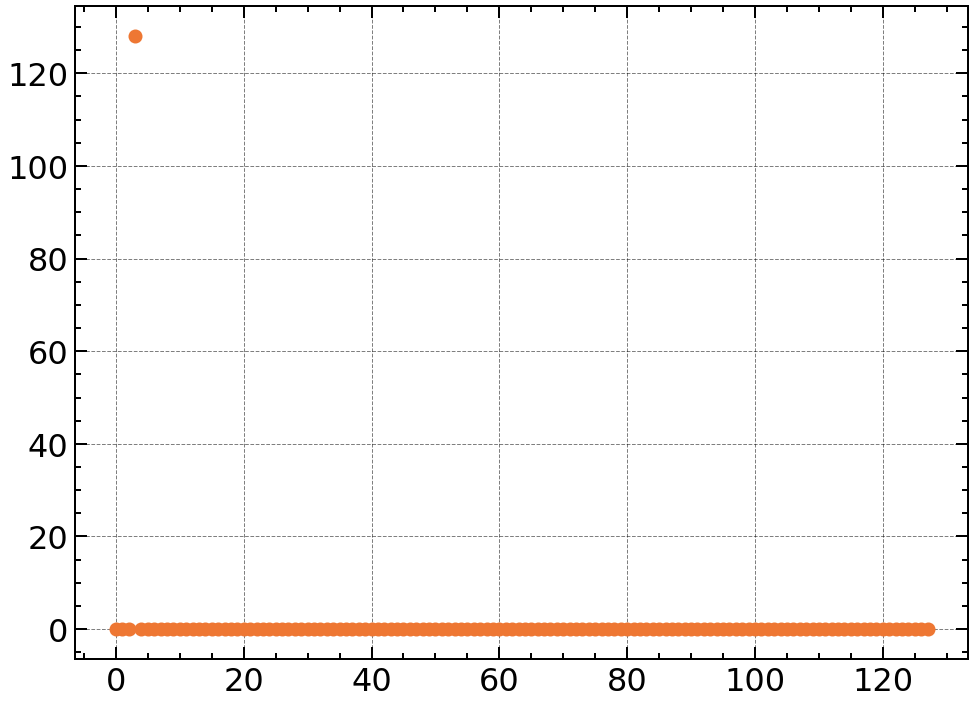

In [4]:
qm = QM1DParticle(128)
_, _, psi = psi_n(qm, 3)
psi_fft = np.fft.fft(psi)
plt.figure(figsize=(8,6))
plt.plot(np.abs(psi_fft), 'o');

Only one frequency in the Fourier-spectrum is not zero, and it is indeed the number of
the plain wave $n=3$ we have chosen:

In [5]:
np.argmax(np.abs(psi_fft))

3

Finally lets try the reverse transformation and compare the result with the original function:

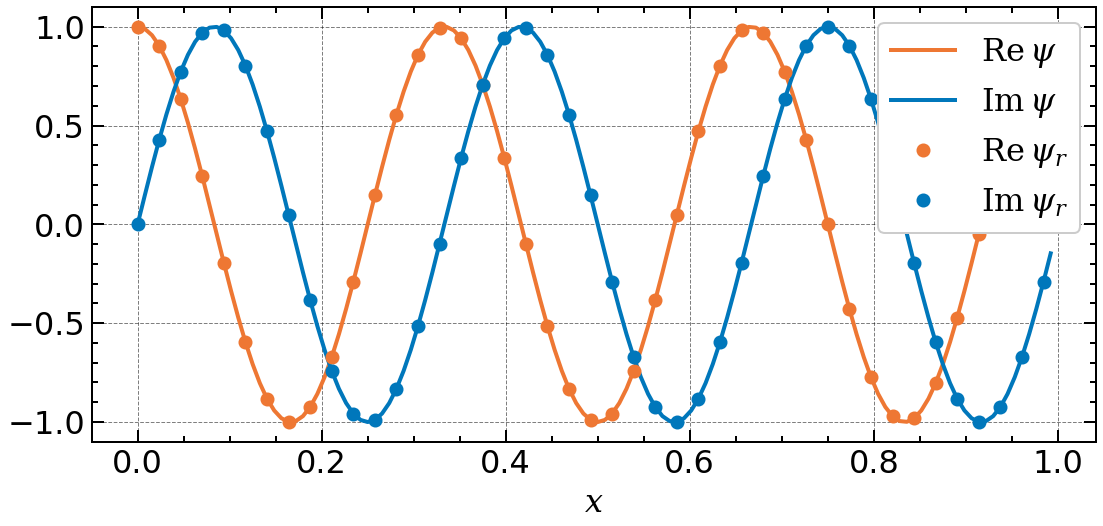

In [6]:
psi_r = np.fft.ifft(psi_fft)

plt.figure(figsize=(9,4))
plt.plot(qm.x, psi.real, label=r"$\mathrm{Re}\,\psi$")
plt.plot(qm.x, psi.imag, label=r"$\mathrm{Im}\,\psi$")
plt.plot(qm.x, psi_r.real, 'o', label=r"$\mathrm{Re}\,\psi_r$", markevery=3, color='#EE7733')
plt.plot(qm.x, psi_r.imag, 'o', label=r"$\mathrm{Im}\,\psi_r$", markevery=3, color='#0077BB')
plt.xlabel('$x$')
plt.legend();

In the graph we plotted the original functions real and imaginary values as continuous curves
and compared these values with the reverse transformed value $\psi_r$, which is plotted
as single dots. As all the dots lie on the curves of the original function $\psi$ it is pretty
obvious, that using `fft` and `ifft` gives back the original function as expected.

Maybe you noticed, that we have chosen a value of $N = 128$ for the spatial resolution of
the quantum system, in contrast to $N=100$ or $N=300$. This was no accident. In the 
[documentation][fft_docu] to the `fft` function we find:

> FFT (Fast Fourier Transform) refers to a way the discrete Fourier Transform (DFT) can be calculated efficiently, by using symmetries in the calculated terms. The symmetry is highest when n is a power of 2, and the transform is therefore most efficient for these sizes.

Ok, let's see, how much more efficient `fft` is for system sizes of $N= 2^m$.

[fft_docu]: https://numpy.org/doc/stable/reference/generated/numpy.fft.fft.html

In [7]:
_, _, psi = psi_n(QM1DParticle(128), 3)
%timeit np.fft.fft(psi)

3.77 µs ± 265 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [8]:
_, _, psi = psi_n(QM1DParticle(129), 3)
%timeit np.fft.fft(psi)

6.32 µs ± 311 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [9]:
_, _, psi = psi_n(QM1DParticle(127), 3)
%timeit np.fft.fft(psi)

9.15 µs ± 222 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


So `fft` for a system of $N=129$ takes roughly two times the running time compare to $N=128$
and for $N=127$ it takes nearly three times as long. Clearly, we better stick to powers of 2 
for the system size as is advised by the documentation!

## Linear Operator

The biggest problem when using the non-local momentum operator as a dense matrix is,
that this means a (memory) complexity of $\mathcal{O}(N^2)$. The `scipy.sparse.linalg` package
provides a class [LinearOperator][Linear_Op], which we can use as a base class to define our own
version of the non-local operator. Using this we can circumvent the creation of $N^2$ entries
of a dense matrix, because the dense matrix can hold *any* linear operation for
$N$-vectors, without any knowledge about the operation. By using the Linear Operator
interface we can encode very specific operations and so reduce the complexity. 

[Linear_Op]: https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.LinearOperator.html#scipy.sparse.linalg.LinearOperator

In [10]:
class FFTMomentum(linalg.LinearOperator):

    def __init__(self, qm):
        super().__init__(dtype='complex128', shape=(qm.N, qm.N))
        n = np.arange(qm.N)
        n = n - qm.N * ((2*n) // qm.N)
        self.p_vec = 2 * np.pi * n * qm.hbar / qm.L
        
    def _matvec(self, v):
        v_fft = np.fft.fft(v)
        return np.fft.ifft(self.p_vec * v_fft)

This class defines a linear operator with the eigenvalues
$p_n = \hbar k_n =  2 \pi \hbar n / L$ for $n= -N/2 \dots N/2 - 1$ and the
operation defined by the method `_matvec` is

$$
\hat P_\textrm{fft} = \sum_{n} p_n \ket{p_n}  \bra{p_n} \, ,
$$

where the bras $\sum_{n} \bra{p_n}$ represent the `fft` part and the kets $\sum_{n} \ket{p_n}$
the inverse `ifft`.

We can test this operator by applying it to a known eigenvector and compare the result by
calculating the following value:

$$
\frac{\hat P_\textrm{fft} \psi_n}{\psi_n} - 1 \approx 0 \, ,
$$

where the vector division is meant to be elementwise. This is shown in the next
graph and one can see, that the result is equal to zero within the limits 
of the numerical precision. So the constructed operator works.

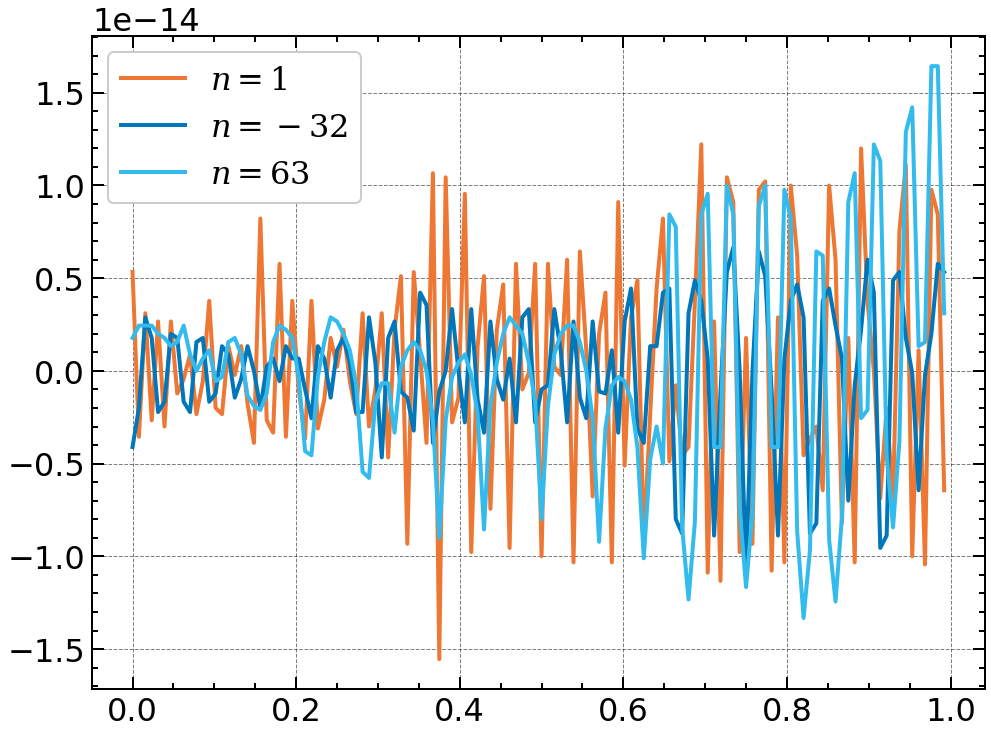

In [11]:
fft_P = FFTMomentum(qm)
plt.figure(figsize=(8,6))
for n in [1, -qm.N//4, qm.N//2 - 1]:
    psi = psi_n(qm, n)[-1]
    p_n = 2 * np.pi * qm.hbar * n / qm.L
    plt.plot(qm.x, np.abs((fft_P @ psi)/psi / p_n) - 1, label='$n=%d$' % n)
plt.legend();

Subclasses of `LinearOperator` work perfectly with the routines for finding eigenvalues:

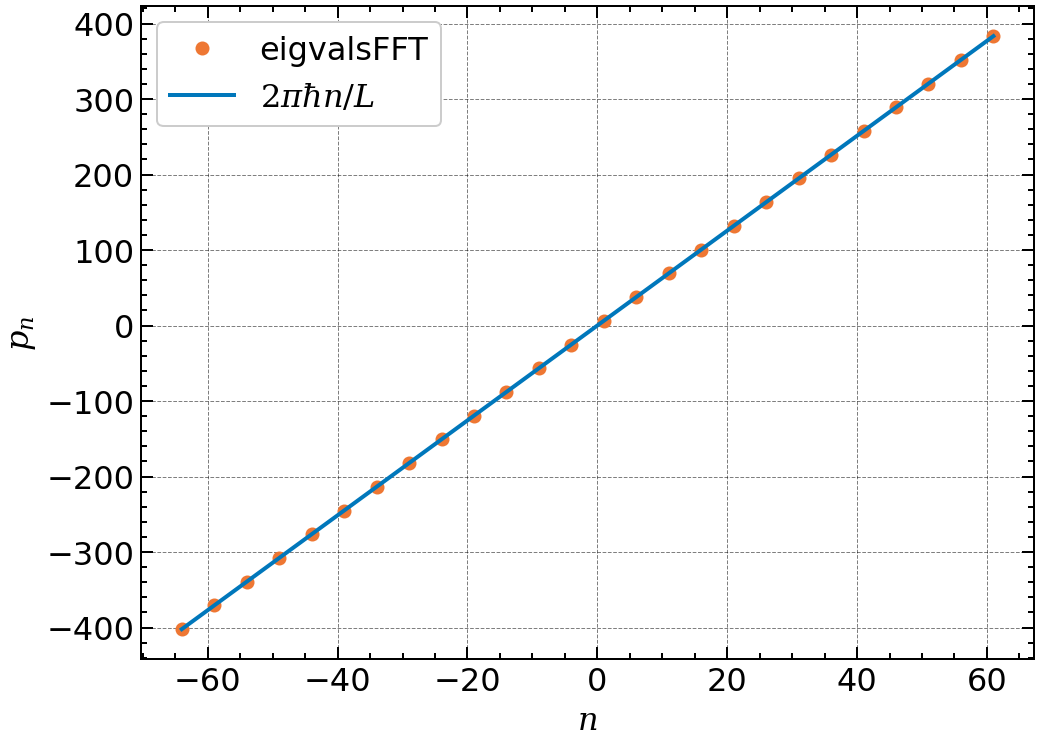

In [12]:
eigvalsFFT, eigvecsFFT = linalg.eigsh(fft_P, k=qm.N - 2, which='SA')
eigs = np.array(sorted(eigvalsFFT))
ns = np.arange(-qm.N//2, qm.N//2)[0:len(eigs)]
pns = 2 * np.pi * qm.hbar * ns / qm.L
plt.figure(figsize=(8,6))
plt.plot(ns, eigs, 'o', label="eigvalsFFT", markevery=5)
plt.plot(ns, pns, label="$2 \pi \hbar n / L$")
plt.xlabel("$n$")
plt.ylabel("$p_n$")
plt.legend();

**&lt;Embarrassing side note&gt;**

I was chasing a very strange
bug for nearly a whole day (a good night's rest helped to clear the head). In the beginning 
the definition of the operator looked like that:

In [13]:
# WRONG implementation!
class FFTMomentum_WRONG(linalg.LinearOperator):

    def __init__(self, qm):
        super().__init__(dtype='complex128', shape=(qm.N, qm.N))
        n = np.arange(qm.N)
        n = n - qm.N * ((2*n) // qm.N)
        self.p_vec = 2 * np.pi * n * qm.hbar / qm.L
        
    def _matvec(self, v):
        v_fft = np.fft.fft(psi)
        return np.fft.ifft(self.p_vec * v_fft)

Can you spot the mistake?

It is this line:
```
        v_fft = np.fft.fft(psi)
```

This came from copy-pasting some code. I missed, that I called the argument `v` and
not `psi`. Normally something like this is detected very quickly, but I used the code
the same way as above, like

```
psi = psi_n(qm, n)[-1]
plt.plot(qm.x, np.abs((fft_P @ psi)/psi / p_n) - 1, label='$n=%d$' % n)
```

And this was really bad luck, because now `psi` was defined and in the expression `fft_P @ psi` the
parameter `v` in `_matvec(self, v)` has the same value as `psi` purely by accident. 
So everything seemed to be fine for the moment.

But once I tried to use `linalg.eigsh` for finding the eigenvalues this was no longer the
case and `eigsh` did not deliver the correct eigenvalues. This was really puzzling and I was
kind of assuming, that `linalg.eigsh` was not able to work with my FFT momentum operator. 

I don't know how to prevent such mistakes in the future. In "normal" python development one 
would use a linter like [Pylint][pylint] to find similar bugs, but in the Jupyter notebook
this is not so easily done. Sure, there is [nbQA][nbQA], but this works only if we pass it
the complete notebook. If one uses Jupyter for *explorative* coding, where we input code
cell by cell and use the output as the next starting point, a tool like nbQA seems to be 
not ideal. But maybe I will give it a try in the future.

**&lt;/Embarrassing side note&gt;**

[pylint]: https://pypi.org/project/pylint/
[nbQA]: https://github.com/nbQA-dev/nbQA

## Speed comparison

Now that we have defined the linear operator it is time to check how this will perform against the alternatives.

As the sparse $\mathbf{D2}$ matrix will perform the second derivative, for a fair comparison
we will construct operators, that will calculate the kinetic energy part:

$$
\hat E_\mathrm{kin} = \frac{\hat p^2}{2 m} \, .
$$

For the non-local matrix from the last blog post, we just switch from $k_n$ eigenvalues
to $E_n$ eigenvalues:

In [14]:
def nonlocal_Ekin_op(qm):
    """Return the nonlocal Ekin operator for the quantum systme qm
    """
    pns = []
    Ens = []
    for n in range(-qm.N//2, qm.N//2):
        En, _, pn = psi_n(qm, n)
        pns.append(pn)
        Ens.append(En)

    # Instead of Q we will construct Q_inv, that is Q^{-1}, because we
    # can simply stack rows of eigenvectors
    Q_inv = np.array([v.T.conj() for v in pns])
    Q = Q_inv.T.conj()
    Lambda = np.diag(Ens)
    # calculate P = Q \Lambda Q^{-1}
    # we also must include the resolution dx in order to get correct scaling
    Pd = Q @ Lambda @ Q_inv * qm.dx         
    return Pd

The Linear Operator equivalent can be defined in the same way:

In [15]:
class FFTD2(linalg.LinearOperator):

    def __init__(self, qm):
        super().__init__(dtype='complex128', shape=(qm.N, qm.N))
        n = np.arange(qm.N)
        n = n - qm.N * ((2*n) // qm.N)
        self.p_vec = 2 * np.pi * n * qm.hbar / qm.L
        self.Ekin_vec = self.p_vec**2 / (2 * qm.mass)
        
    def _matvec(self, v):
        v_fft = np.fft.fft(v)
        return np.fft.ifft(self.Ekin_vec * v_fft)

We could also use the square of the momentum operator for the kinetic energy operator `fftP @ fftP` with `fftP = FFTMomentum(qm)`. But this would result in applying the python operation two times, which is not very efficient.

The [sparse local operator][sparse_local] is 

[sparse_local]: https://znswanderer.github.io/physics/Discrete/

In [16]:
def sparse_D2(qm):
    return sparse.diags([1, -2, 1, 1, 1], [-1, 0, 1, qm.N-1, -qm.N+1], shape=(qm.N, qm.N)) / qm.dx**2

And to test this inside a Linear Operator interface we define a (not very useful) operator:

In [17]:
class SparseLocalD2(linalg.LinearOperator):
    def __init__(self, qm):
        super().__init__(dtype='complex128', shape=(qm.N, qm.N))
        self.D2 = sparse_D2(qm)
    
    def _matvec(self, v):
        return self.D2 @ v

But the sparse operators only define the second derivative. So, just to make everything comparable,
we provide a convinience function, that construct an $E_\mathrm{kin}$ operator from $\mathbf{D2}$ operators:

In [18]:
def Ekin_opr_factory(d2_class):
    def f(qm):
        return -d2_class(qm) * (qm.hbar**2 / (2*qm.mass))
    return f

With these definitions we can now compare the running times for the operators:

In [19]:
operators = [('FFT LO', FFTD2), 
             ('NL Matrix', nonlocal_Ekin_op),
             ('sparse D2', Ekin_opr_factory(sparse_D2)), 
             ('sparse LO', Ekin_opr_factory(SparseLocalD2))
            ]
resolutions = [64, 128, 256, 512, 1024]

In [20]:
import timeit 
from collections import defaultdict

times = defaultdict(list)
for res in resolutions:
    for name, opr_class in operators:
        qm = QM1DParticle(N=res)
        oprt = opr_class(qm)
        t = timeit.timeit(lambda: linalg.eigsh(oprt, k=oprt.shape[0] - 2, which='SA'), number=1)
        times[name].append(t)

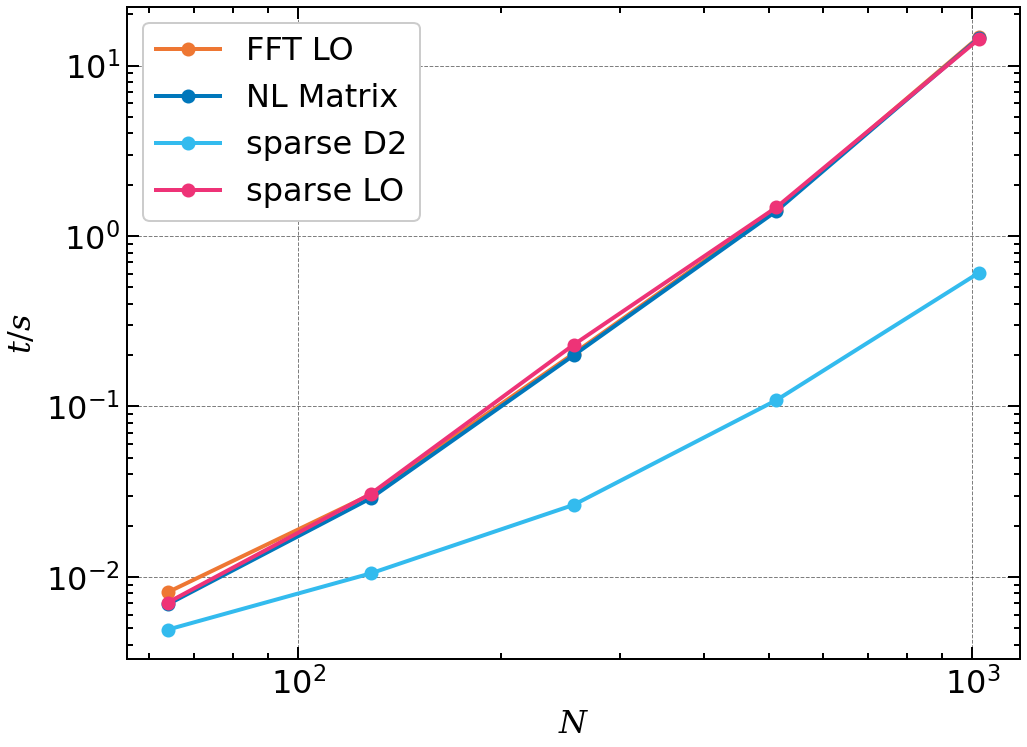

In [21]:
plt.figure(figsize=(8,6))

for name, results in times.items():
    plt.plot(resolutions, results, 'o-', label=name)

plt.yscale('log')
plt.xscale('log')
plt.xlabel('$N$')
plt.ylabel('$t/s$')
plt.legend();

The plot shows clearly, that the pure sparse matrix solution (sparse D2) is by far the most efficient
way to calculate eigenvalues, at least in our naive implementation. 

The use of the Linear Operator interface with FFT calculation (FFT LO) does not yield more efficiency
compared to the simple dense matrix approach (NL Matrix). Also if we embed the sparse matrix
operator inside the Linear Operator interface (sparse LO) the performance is as bad as the non-local 
operators.

The fact, that "FFT LO", "NL Matrix" and "sparse LO" show more or less the same performance
and the performance of the pure sparse matrix (sparse D2) is so much better, seems to show,
that the bad performance is not due to the Linear Operator interface, because "NL Matrix" has the
same performance, but rather that there is a dedicated optimization for sparse matrices at work,
which makes "sparse D2" so much more performant.

## Harmonic Oscillator

The pure performance of the operators itself might not be the most important key figure.
For example we might want to calculate the first $M$ eigenvalues of a system like 
the harmonic oscillator. As we seen last time, using the non-local momentum operator
we were able to get good approximations for the energy eigenvalues using a much lower
spatial resolution $N$ compared to the local operators. So a fair comparison
would be to compare running times per energy eigenvalue quality.

The harmonic oscillator system:

In [22]:
def X_op(qm, x0=0):
    """The position space operator"""
    return sparse.diags([qm.x - x0], [0])

class SHO:
    """Simple harmonic oscillator"""
    def __init__(self, qm, Ekin_opr, omega):
        self.qm = qm
        self.omega = omega
        self.Ekin_opr = Ekin_opr
        x0 = np.average(qm.x)
        X = X_op(qm, x0)
        if isinstance(Ekin_opr, linalg.LinearOperator):
            X2 = linalg.aslinearoperator(X @ X)
        else:
            X2 = X @ X
        self.Epot_opr = 0.5 * qm.mass * omega**2 * X2
        self.hbar_omega = qm.hbar * omega
        
    def Hamiltonian(self):
        return (self.Ekin_opr + self.Epot_opr)

We now take a low-resolution ($N=64$) system and calculate the first 35 eigenvalues with the 
non-local momentum operator:

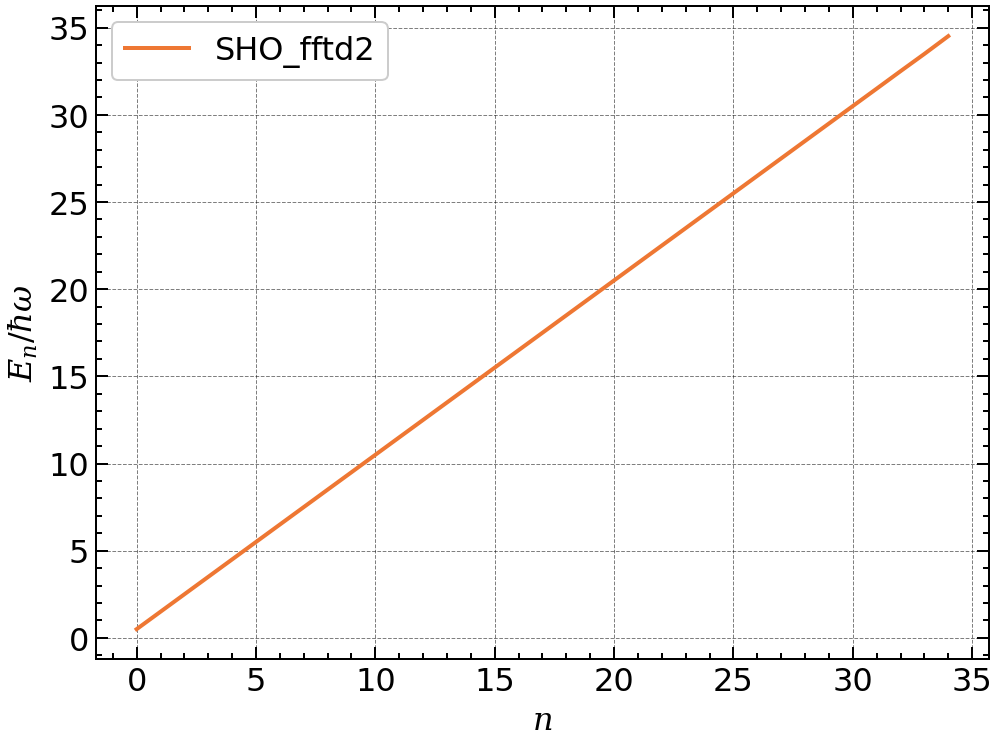

In [23]:
qm = QM1DParticle(N=64)
SHO_fftd2 = SHO(qm, Ekin_opr=FFTD2(qm), omega=500)

plt.figure(figsize=(8,6))
eigs_fftd2, _ = linalg.eigsh(SHO_fftd2.Hamiltonian(), k=35, which='SA')
plt.plot(sorted(eigs_fftd2/SHO_fftd2.hbar_omega), label='SHO_fftd2')
plt.ylabel(r'$E_n/\hbar \omega$')
plt.xlabel(r'$n$')
plt.legend();

These eigenvalues are pretty good compared to the analytic solutions. The
calculation time for these eigenvalues is:

In [24]:
%timeit linalg.eigsh(SHO_fftd2.Hamiltonian(), k=35, which='SA')

7.22 ms ± 141 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


We now want to get eigenvalues of similar quality with the sparse local operator.
Here we have to go to a resolution of $N=300$ to get results of similar quality:

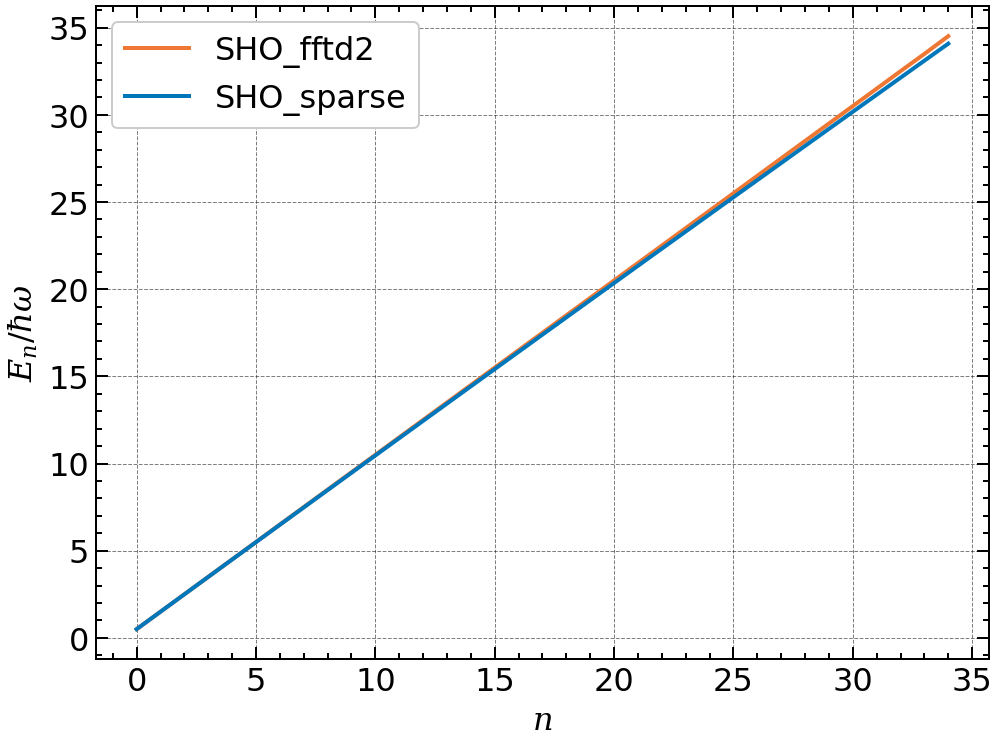

In [25]:
qm2 = QM1DParticle(N=300)
SHO_sparse = SHO(qm2, Ekin_opr=Ekin_opr_factory(sparse_D2)(qm2), omega=500)

eigs_sparse, _ = linalg.eigsh(SHO_sparse.Hamiltonian(), k=35, which='SA')

plt.figure(figsize=(8,6))
plt.plot(sorted(eigs_fftd2/SHO_fftd2.hbar_omega), label='SHO_fftd2')
plt.plot(sorted(eigs_sparse/SHO_sparse.hbar_omega), label='SHO_sparse')
plt.ylabel(r'$E_n/\hbar \omega$')
plt.xlabel(r'$n$')
plt.legend();

The running time is now:

In [26]:
%timeit linalg.eigsh(SHO_sparse.Hamiltonian(), k=35, which='SA')

19.7 ms ± 688 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


So, at least in this example it is more efficient to use the non-local operator 
for calculating the lowest energy eigenvalues with good quality.

## Conclusion

Using the Linear Operator interface of scipy.sparse.linalg we can formulate the non-local
momentum operator using FFT very compactly. However calculating eigenvalues with 
this operator is slower than using the highly optimized routines for sparse matrices.
On the other hand, if we do not compare running times for a fixed resolution $N$, but for a 
target quality of the lowest eigenvalues, the non-local operator can become
more efficient than the sparse local operator.

Maybe in the end it will be best to decide case by case which operator to use
for a given problem.

There is also the more sophisticated package [pylops][pylops], which as based on the
Linear Operator from scipy. I only skimmed this package, but it seems to be promising if
one is interested in using linear operators.

[pylops]: https://github.com/PyLops/pylops

## Addition (2021-09-01)

The scipy function `linalg.eigsh`, which we used above, is quite general and allows
all possible matrices and linear operators as arguments. But the local $\mathbf{D2}$ matrix that
we use has a very special form, namely that it only takes values on the main diagonal
and the directly adjacent diagonals. In the scipy module there is a special function
`scipy.linalg.eigh_tridiagonal` for exactly such cases. Such special functions are optimized and
have better performance than the more general functions, as we will see below:

In [27]:
omega = 500
diag = 0.5 * qm2.mass * omega**2 * (qm2.x - 0.5)**2 + qm2.hbar**2 / (qm2.mass * qm2.dx**2)
off_diag = - qm2.hbar**2 /(2 * qm2.mass * qm2.dx**2) * np.ones(len(qm2.x) - 1)

In [28]:
from scipy.linalg import eigh_tridiagonal
eigvals_tri, eigvecs_tri = eigh_tridiagonal(diag, off_diag, select='i', select_range=(0, 34))

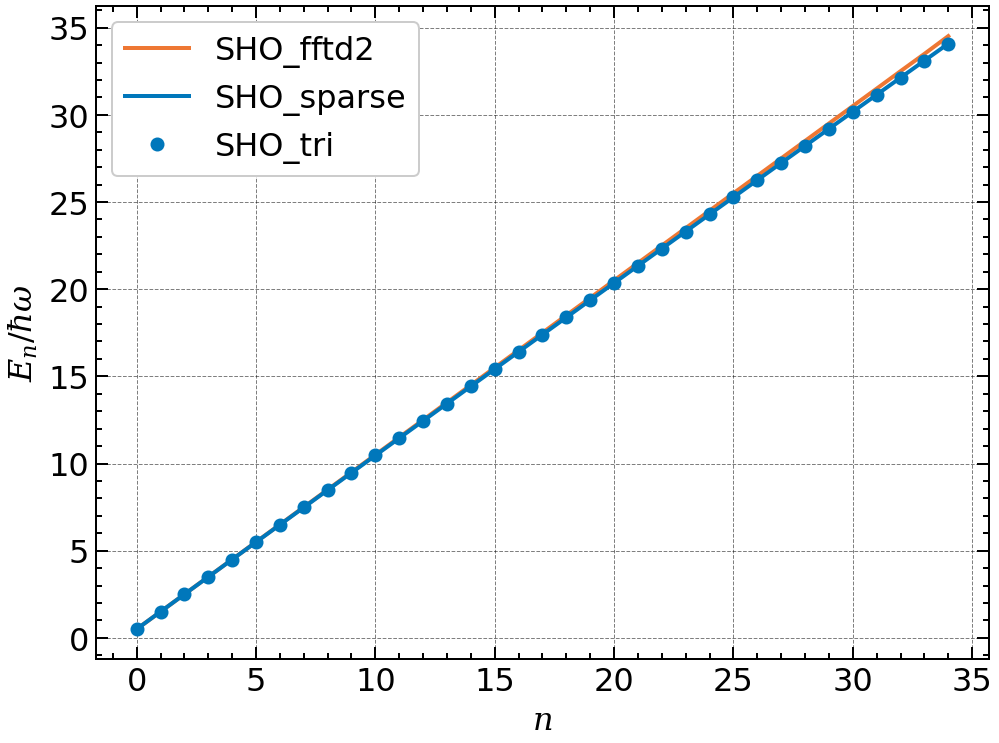

In [29]:
plt.figure(figsize=(8,6))
plt.plot(sorted(eigs_fftd2/SHO_fftd2.hbar_omega), label='SHO_fftd2')
plt.plot(sorted(eigs_sparse/SHO_sparse.hbar_omega), label='SHO_sparse')
plt.plot(eigvals_tri/(qm2.mass * omega), 'o', color='#0077BB', label='SHO_tri')
plt.ylabel(r'$E_n/\hbar \omega$')
plt.xlabel(r'$n$')
plt.legend();

So this method yields exactly the same eigenvalues as the use of the more general
function `linalg.eigsh`. However, the runtime is now much better:

In [30]:
%timeit eigh_tridiagonal(diag, off_diag, select='i', select_range=(0, 34))

3.33 ms ± 173 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


With this we have again a better performance than with the non-local operator!